# Bayesian Linear Regression

In this notebook, we see how Bayesian linear regression algorithm (including the evidence approximation) described in chapter 3 of PRML can be implemented. 

* First, we consider fixed hyper parameters, and do linear regression. 
* Next, we implement empirical Bayes (i.e., evidence approximation), where hyper parameters are determined from data.

In [1]:
import numpy as np
import matplotlib as mpl
from scipy.linalg import eigh
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1 Setting


### 1.1 Basic notations
* Let $N \in \mathbb{N}$ be the number of data points.
* Let $d \in \mathbb{N}$ be the dimension of the input.
* Denote input data as $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$, and output data as $t_0, t_1, \dots, t_{N-1} \in \mathbb{R}$. 
Also, let $\boldsymbol{t} = {}^t (t_0, t_1 \dots, t_{N-1}) \in \mathbb{R}^N$.


### 1.2 Example data

As an example, we use $d=1, N = 50$ data, where $x_i \in \mathbb{R}$ are drawn from uniform distribution over $[-3,3]$, and
\begin{eqnarray}
    &{}& t = f(x) + \varepsilon \\
    &{}& f(x) = \sin(2x)  + 0.2\sin x + 0.1x \\
    &{}& \varepsilon \sim \mathcal{N}(0, 0.09)
\end{eqnarray}
The dataset is shown below:

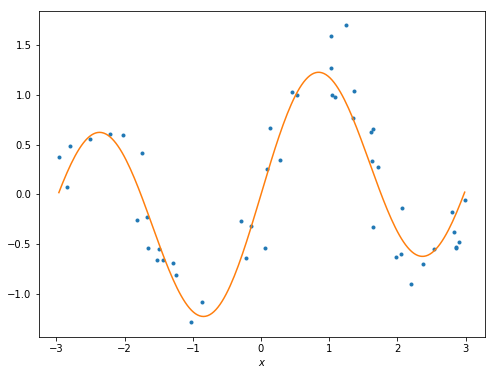

In [17]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

numdat = 50
xdat = np.random.uniform(-3,3,numdat)
ep = 0.3*np.random.randn(numdat)
ydat = truef(xdat) + ep

xcont = np.linspace(np.min(xdat),np.max(xdat),200)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.')
plt.plot(xcont,truef(xcont))
plt.xlabel(r'$x$')
plt.show()

xdat = np.reshape(xdat,(len(xdat),1))
xtest = np.reshape(xcont,(len(xcont),1))

## 2 Model and basis functions

### 2.1 Model

We assume the following model: 
\begin{equation}
    p(t|x,w,\beta) = \mathcal{N}(t|w^{T}\phi(x),\beta^{-1})
    = \sqrt{\frac{\beta}{2\pi}} \exp\left\{-\frac{\beta}{2} \left[ t - w^{T}\phi(x) \right]^2  \right\},
\end{equation}
where
* $\beta > 0$ is the precision of the Gaussian distribution, which is a hyper parameter,  
* $w \in \mathbb{R}^d$is a parameter (weight), 
* $\phi : \mathbb{R}^d \rightarrow \mathbb{R}^M $ are basis functions which we specify later, and $\phi(x) := (\phi_0(x), \phi_1(x), \dots, \phi_{M-1}(x))^T$ with $M$ being the number of basis functions. 

The model means that the output $t$ is the sum of a function of $x$ and a noise $\varepsilon \sim \mathcal{N}(0,\beta^{-1})$.

We also assume that, given the inputs $x_0, x_1, \dots, x_{N-1}$, the output $t_0, t_1 \dots, t_{N-1}$ are generated independently according the above model with $x$ being the corresponding input data.

For the later convenience, let tha matrix $\Phi$, which is sometimes called a design matrix, be
\begin{equation}
    \Phi = (\Phi_{i,j}), \ \ \Phi_{i,j} = \phi_j(x_i). 
\end{equation}
Note that the shape of $\Phi$ is $N \times M$.


### 2.2 Basis functions

As basis functions, we use Gaussian basis functions in this notebook, where we set
\begin{equation}
    \phi_0 (x) = 1
\end{equation}
\begin{equation}
    \phi_j(x) = \exp\left[ -\frac{(x-\mu_j)^2}{2 s^2} \right] \ \ (j = 1, \dots, M-1), 
\end{equation}
where $\mu_j$ and $s$ stands for the center and the width of each Gaussian, respectively, which are assumed to be given.

Below we show the plot of a set of basis functions: 

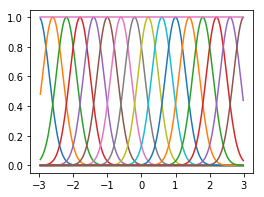

In [18]:
mus = np.linspace(-3,3,16)
s = 0.3
cnt = 0
plt.figure(figsize=(4,3))
while cnt < len(mus):
    plt.plot(xcont,np.exp(-(xcont-mus[cnt])**2/(2*s*s)))
    cnt += 1
plt.plot(xcont,np.ones(len(xcont)))
plt.show()

### 2.3 code : generating design matrix

Here we give a function that generate the design matrix $\Phi$ from input data and $\mu_j$ s and $s$.

In the following code, we have vectorized the calculation of $\phi_j(x)$, which is a little bit tricky, so let's take a closer look.

The $(n,m+1)$ component of $\Phi$ can be expressed as ($X$ stands for 'X', and $\mathcal{M}$ stands for params['mus'])

\begin{equation}
    \Phi_{n,m+1} = \exp\left[ -\frac{1}{2 s^2} \sum_{i=1}^{d} \left(X_{n,i} - \mathcal{M}_{m,j} \right)^2 \right]
\end{equation}

Because we can apply 'np.exp' elementwise, it suffices to consider the quantity

$$
\begin{align}
    A_{n,m} &:= \sum_{i=1}^{d} \left(X_{n,i} - \mathcal{M}_{m,i} \right)^2 \\
    &= \sum_{i=1}^{d} X_{n,i}^{2} + \sum_{i=1}^{d} \mathcal{M}_{m,i}^{2} - 2 \sum_{i=1}^{d} X_{n,i} \mathcal{M}_{m,i}
\end{align}
$$

Then, we can calculate the (N,M-1) array A with numpy broadcasting (see the following code):

* 1: First, "-2*(X@np.transpose(mus))" creates a (N,M-1) array, which corresponds to the third term of the above equation.
* 2: Then, np.reshape(np.sum(X**2,axis=1),(len(X),1)) create a (N,1) array, which corresponds to the first term of the above equation. The array will be added to the (N,M-1)array created earlier, where numpy broadcasting take care of matching the shape of the array (Note that the reshape command is required here).
* 3: Finally, np.sum(mus**2,axis=1) create a (M-1,) array, which corresponds to the second term in the above equation. When the array is added to the (N,M-1) array, broadcasting takes place too.

In [19]:
# input 
#    * X : (N,d) numpy array, with X[n] = x_n
#    * params : dictionary, assumed to have
#        params['mus'] : (M-1,d) numpy array. params['mus'][j] being the center of the jth Gaussian
#        params['s'] : double. positive real number, which stands for the width of Gaussians
# output
#    * out : (N,M) array \Phi
def gen_desmat(X,params):
    s = params['s']
    mus = params['mus']
    out = np.zeros((len(X),len(mus)+1))
    out[:,0] = np.ones(len(X))
    A = ( -2*(X@np.transpose(mus)) + np.reshape(np.sum(X**2,axis=1),(len(X),1)) ) + np.sum(mus**2,axis=1)
    out[:,1:] = np.exp(-A/(2*s*s))
    return out

## 3 Bayesian linear regression

### 3.1 Posterior distribution of the parameter $w$

From the model describe in the previous section, the likelihood is given by
\begin{equation}
    p(t_1, \dots, t_N | w, \beta) = \prod_{n=1}^{N} \mathcal{N}(t_n|w^T\phi(x_n), \beta^{-1}). 
\end{equation}

As a prior for $w$, we take
\begin{equation}
    p(w|\alpha) = \mathcal{N}(w|m_0,S_0), 
\end{equation}
where $m_0 \in \mathbb{R}^M$, and $S_0$ is a $(M,M)$ real positive-definite symmetric matrix.

With this prior, the posterior distribution becomes (see (3.49)-(3.51) of the book):
\begin{eqnarray}
    &{}& p(w|t_1, \dots , t_n) = \mathcal{N}(w|m_N,S_N) \\
    &{}& m_N := S_N (S_{0}^{-1}m_0 + \beta \Phi^T t) \\
    &{}& S_N := \left( S_{0}^{-1} + \beta \Phi^T \Phi \right)^{-1} \\
    &{}& \Phi = (\Phi_{i,j}), \ \ \Phi_{i,j} = \phi_j(x_i)
\end{eqnarray}
In particular, if we set $m_0 = 0$, $S_0 = \frac{1}{\alpha} I$, we have:
\begin{eqnarray}
    &{}& m_N := \beta S_N \Phi^T t \\
    &{}& S_N := \left( \alpha I  + \beta \Phi^T \Phi \right)^{-1}
\end{eqnarray}
From now on, we assume this form of $m_0, S_0$. 

Under these assumptions, here we give a function that calculate $m_N, S_N$ from the design matrix $\Phi$, output data $\boldsymbol{t}$, and hyper parameters $\alpha, \beta$.

In [20]:
# input 
#    * Phi: (N,M) numpy array. design matrix
#    * tdat : (N,) numpy array. output data
#    * alpha : double, positive. The precision of the prior.
#    * beta : double, positive. The precision of the model.
# output
#    * m : (M,) numpy array m_N
#    * S : (M,M) numpy array S_N
def posterior_mS(Phi,tdat,alpha,beta):
    S = np.linalg.inv(alpha*np.identity(len(Phi[0])) + beta*np.transpose(Phi)@Phi )
    m = beta*S@ np.transpose(Phi)@ tdat
    return m,S

### 3.2 Predictive distribution

From the posterior distribution of $w$, we can compute the predictive distribution of $t$ (see (3.57)-(3.59) of the book)
\begin{eqnarray}
    p(t| x, \boldsymbol{t}, \alpha, \beta)
    & := & \int dw \ p(t|x, w,\beta) p(w | \boldsymbol{t}, \alpha, \beta) \\
    & = & \mathcal{N}(t| m_{N}^{T} \phi(x), \sigma_{N}^{2}(x)) ,  
\end{eqnarray}
where
\begin{equation}
    \sigma_{N}^{2}(x) = \frac{1}{\beta} + \phi(x)^T S_N \phi(x)
\end{equation}

Given below is the function that calculate the mean $m_{N}^{T} \phi(x)$ and the variance $\sigma_{N}^{2}(x)$ of predictive distribution. 
Note that "Phi_test" is a design matrix coresponding to test data input. 

In [21]:
# input 
#    * Phi_test: (N_test,M) numpy array. design matrix corresponding to 
#    * m : (M,) numpy array. mean of the posterior distribution
#    * S : (M,M) numpy array. The precision matrix of the posterior distribution.
#    * alpha : double, positive. The precision of the prior.
#    * beta : double, positive. The accuracy of the model.
# output
#    * pred_mu : (N_test,) numpy array. m_N
#    * pred_sigma : (N_test,) numpy array. S_N
def pred_MuSigma(Phi_test, m, S, alpha, beta):
    pred_mu = Phi_test@m
    pred_sigma = np.sqrt(1.0/beta + np.diag(Phi_test @ S @ np.transpose(Phi_test) ) )
    return pred_mu, pred_sigma

### 3.3 Run with the sample data

With these functions, we can now obtain our prediction (Here, $s, \alpha, \beta$ are chosen by hand.).

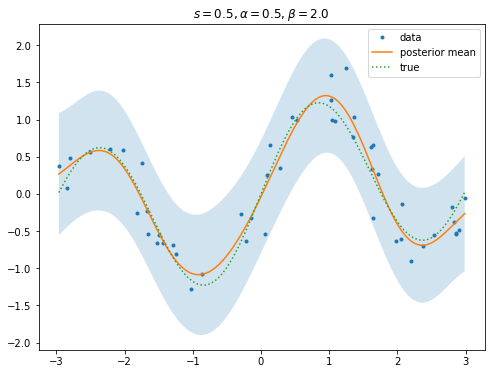

In [22]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
alpha = 0.5
beta = 2.0
params = {'s':s, 'mus':mus}

Phi = gen_desmat(xdat,params = {'s':s, 'mus':mus})
m,S = posterior_mS(Phi,ydat,alpha,beta)

Phi_test = gen_desmat(xtest,params)
pred_mu,pred_sigma = pred_MuSigma(Phi_test,m,S,alpha,beta)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont,pred_mu,label='posterior mean')
plt.plot(xcont,truef(xcont),':',label='true')
plt.fill_between(xcont,pred_mu+pred_sigma,pred_mu-pred_sigma,alpha=0.2)
plt.title(r'$s=%s,\alpha=%s,\beta=%s$'%(s,alpha,beta))
plt.legend()
plt.show()

It seems that we are lucky, because, even though hyperparameters are chosen by hand without much consideration, the result looks not bad. 

However, if we are not lucky enough, we get weird results:


(e.g.1) too small $s$:

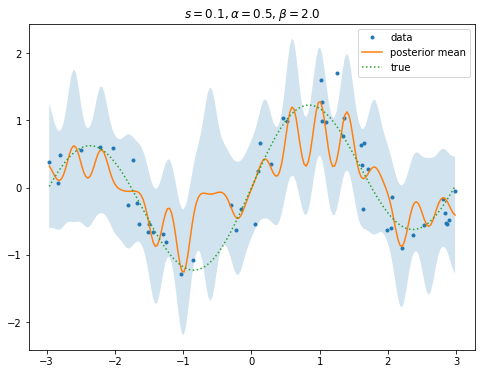

In [23]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.1
alpha = 0.5
beta = 2.0
params = {'s':s, 'mus':mus}

Phi = gen_desmat(xdat,params = {'s':s, 'mus':mus})
m,S = posterior_mS(Phi,ydat,alpha,beta)

Phi_test = gen_desmat(xtest,params)
pred_mu,pred_sigma = pred_MuSigma(Phi_test,m,S,alpha,beta)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont,pred_mu,label='posterior mean')
plt.plot(xcont,truef(xcont),':',label='true')
plt.fill_between(xcont,pred_mu+pred_sigma,pred_mu-pred_sigma,alpha=0.2)
plt.title(r'$s=%s,\alpha=%s,\beta=%s$'%(s,alpha,beta))
plt.legend()
plt.show()

(e.g.2) Too large $\alpha$

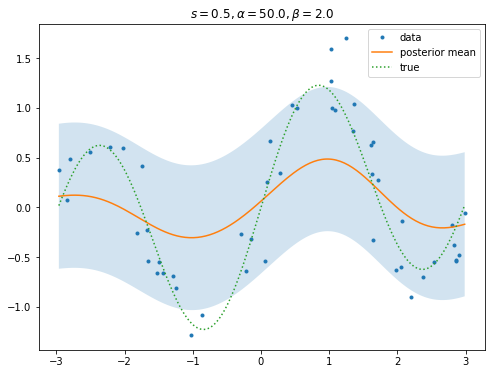

In [24]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
alpha = 50.0
beta = 2.0
params = {'s':s, 'mus':mus}

Phi = gen_desmat(xdat,params = {'s':s, 'mus':mus})
m,S = posterior_mS(Phi,ydat,alpha,beta)

Phi_test = gen_desmat(xtest,params)
pred_mu,pred_sigma = pred_MuSigma(Phi_test,m,S,alpha,beta)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont,pred_mu,label='posterior mean')
plt.plot(xcont,truef(xcont),':',label='true')
plt.fill_between(xcont,pred_mu+pred_sigma,pred_mu-pred_sigma,alpha=0.2)
plt.title(r'$s=%s,\alpha=%s,\beta=%s$'%(s,alpha,beta))
plt.legend()
plt.show()

So far, we have chosen the value of hyper parameters by hand, but we would prefer if we can determine appropriate values of hyper parameters from data. 
That's what we will do in the next section.

## 4 Empirical Bayes

In empirical Bayes method (or evidence approximation), we determine hyper parameters from our data, 
by selecting hyper parameters that maximize evidence (or marginal likelihood).

Here, we just consider maximization with respect to $\alpha, \beta, s$ only, and regard $\mu_j$ as fixed.

### 4.1 Evidence

The evidence $p(\boldsymbol{t}|\alpha,\beta)$ is given by (see (3.86) of the book):

\begin{eqnarray}
    \log p(\boldsymbol{t}|\alpha,\beta) 
    &=& \frac{M}{2} \log \alpha + \frac{N}{2} \log \beta - E(m_N) - \frac{1}{2} \log\left|\alpha I_M + \beta \Phi^T \Phi\right| - \frac{N}{2} \log ( 2\pi) \\
    E(m_N) &:=& 
    \frac{\beta}{2} \| \boldsymbol{t} -  \Phi m_N \|^2 + \frac{\alpha}{2} m_{N}^{T} m_{N}
\end{eqnarray}

Note that $m_N$ depends on $\alpha, \beta$.

Given below is the function that calculate the evidence:

In [25]:
# marginal likelihood
def evidence(Phi,tdat,alpha,beta):
    m,S = posterior_mS(Phi,tdat,alpha,beta)
    M = len(Phi[0])
    N = len(Phi)
    return 0.5*M*np.log(alpha) + 0.5*N*np.log(beta) \
            - 0.5*beta*np.linalg.norm( tdat - Phi@m )**2 - 0.5*alpha*m@m \
            - 0.5*np.log( np.linalg.det( alpha*np.eye(M) + beta*np.transpose(Phi)@Phi ) ) \
            - 0.5*N*np.log(2*np.pi)

### 4.2 Maximization with respect to $\alpha,\beta$

By differentiating the log of evidence, we obtain the stationary conditions (see (3.91), (3.92), (3.95) of the book) : 
\begin{eqnarray}
    \lambda_i &:& \ \mbox{Eigenvalues of } \beta\Phi^T \Phi \\
    \gamma &:=& \sum_{i=1}^{M} \frac{\lambda_i}{ \lambda_i + \alpha} \\
    \alpha &=& \frac{\gamma}{m_{N}^{T} m_{N} } \\
    \beta &=& \frac{N-\gamma}{\| \boldsymbol{t} - \Phi m_N \|^2}
\end{eqnarray}

Note that $\gamma$, $m_N$ depends on $\alpha,\beta$.
We solve these equations iteratively as follows.

In [26]:
def EmpB(Phi,tdat,alpha0,beta0,ep,maxiter,disp_iter=False):
    tmp_lambdas = eigh(np.transpose(Phi)@Phi)[0]
    alpha = alpha0
    beta = beta0
    cnt = 0
    while cnt < maxiter:
        lambdas = tmp_lambdas*beta
        m,S = posterior_mS(Phi,tdat,alpha,beta)
        alpha_old = alpha
        beta_old = beta
        gam = np.sum( lambdas/ (alpha + lambdas) )
        alpha = gam/np.dot(m,m)
        beta = (len(tdat)-gam)/( np.linalg.norm(tdat -  Phi@m )**2    )
        if (abs(alpha-alpha_old) < ep) and ( abs(beta-beta_old)<ep ):
            break
        cnt += 1
    if disp_iter:
        print(f"iteration steps : {cnt}")
    return alpha,beta

A result of this procedure is shown below:

iteration steps : 3


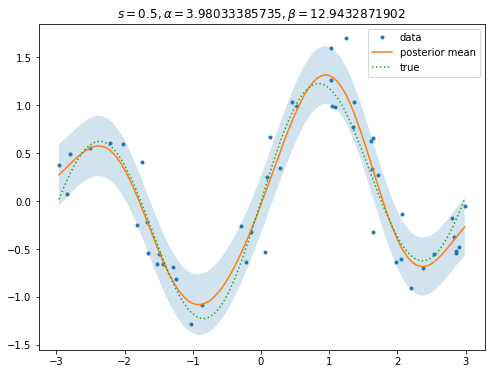

In [27]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
params = {'s':s, 'mus':mus}
Phi = gen_desmat(xdat,params = {'s':s, 'mus':mus})

alpha0 = 1.0
beta0 = 1.0
alpha,beta = EmpB(Phi,ydat,alpha0,beta0,0.0001,1000,disp_iter=True)

m,S = posterior_mS(Phi,ydat,alpha,beta)
Phi_test = gen_desmat(xtest, params)
pred_mu,pred_sigma = pred_MuSigma(Phi_test,m,S,alpha,beta)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont,pred_mu,label='posterior mean')
plt.plot(xcont,truef(xcont),':',label='true')
plt.fill_between(xcont,pred_mu+pred_sigma,pred_mu-pred_sigma,alpha=0.2)
plt.legend()
plt.title(r'$s=%s,\alpha=%s,\beta=%s$'%(s,alpha,beta))
plt.show()

It can be seen that credible intervals become smaller than those seen in the previous section.

### 4.3 Maximization with respect to $s$

Finally, we determine the value of $s$ from our data (assuming $\mu_j$s are fixed).

Because this procedure cannot be carried out analytically, we perform grid search, and plot the value of evidence for each $s$ (Note that the maximization with respect to $\alpha,\beta$ is performed for each $s$.). 

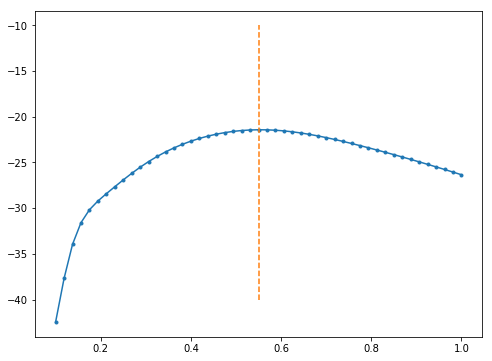

In [28]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))

alpha0 = 1.0
beta0 = 1.0

ss = np.linspace(0.1,1.0,49)
arr_evidence = np.zeros(len(ss))
for (cnt,s) in enumerate(ss):
    Phi = gen_desmat(xdat,{'s':s, 'mus':mus})
    alpha,beta = EmpB(Phi,ydat,alpha0,beta0,0.0001,1000)
    arr_evidence[cnt] = evidence(Phi,ydat,alpha,beta)

s = ss[np.argmax(arr_evidence)]

plt.figure(figsize=(8,6))
plt.plot(ss,arr_evidence,'.-')
plt.plot([s,s],[-40,-10],'--')
plt.show()

With this optimal values of $s, \alpha, \beta$, we obtain the following plot:

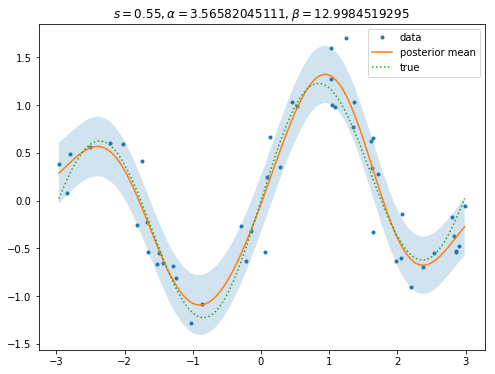

In [29]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
params = {'s':s, 'mus':mus}
alpha0 = 1.0
beta0 = 1.0

s = ss[np.argmax(arr_evidence)]
Phi = gen_desmat(xdat,params)
alpha,beta = EmpB(Phi,ydat,alpha0,beta0,0.0001,1000)

m,S = posterior_mS(Phi,ydat,alpha,beta)
Phi_test = gen_desmat(xtest,params)
pred_mu,pred_sigma = pred_MuSigma(Phi_test,m,S,alpha,beta)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont,pred_mu,label='posterior mean')
plt.plot(xcont,truef(xcont),':',label='true')
plt.fill_between(xcont,pred_mu+pred_sigma,pred_mu-pred_sigma,alpha=0.2)
plt.legend()
plt.title(r'$s=%s,\alpha=%s,\beta=%s$'%(s,alpha,beta))
plt.show()

## Appendix : scikit-learn

In this appendix, we see how we can use the scikit-learn library to perform the above analysis.

Strictly speaking, the implementention is slightly different from ours in that they also consider priors (which are Gamma distributions) on $\alpha$ and $\beta$. 

However, if we take the priors to be uninformative, the result closely resembles to the result shown above.

For detail, see official documentations :
* http://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html

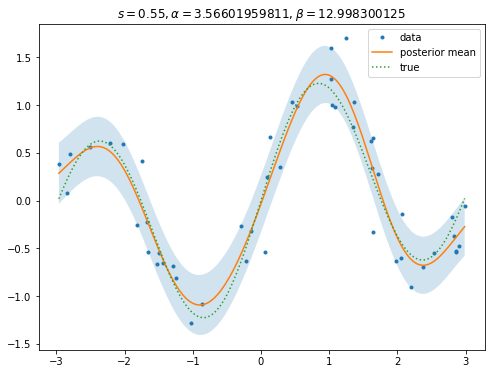

In [36]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(fit_intercept=False)

# prepare the design matrix
mus = np.reshape(np.linspace(-3,3,16),(16,1))
params = {'s':s, 'mus':mus}

# perform the fitting (optimization with respect to alpha and beta is also performed)
Phi = gen_desmat(xdat,params = {'s':s, 'mus':mus})
reg.fit(Phi,ydat)

Phi_test = gen_desmat(xtest,params)
pred_mu,pred_sigma = reg.predict(Phi_test, return_std=True)

plt.figure(figsize=(8,6))
plt.plot(xdat,ydat,'.',label='data')
plt.plot(xcont,pred_mu,label='posterior mean')
plt.plot(xcont,truef(xcont),':',label='true')
plt.fill_between(xcont,pred_mu+pred_sigma,pred_mu-pred_sigma,alpha=0.2)
plt.legend()
plt.title(r'$s=%s,\alpha=%s,\beta=%s$'%(s,reg.lambda_,reg.alpha_))
plt.show()